In [234]:
# import modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns
import dask
import geopandas as gpd
import rasterio.mask
from shapely.geometry import mapping
import rioxarray
from rasterio import features
from affine import Affine
from pyhdf.SD import SD, SDC
from sklearn.metrics import r2_score
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

In [235]:
# AOD DIRECTORY
aod_file = glob.glob('./Data/AOD/*')
aod_file

['./Data/AOD\\3DR_2022_23',
 './Data/AOD\\3D_2014_15',
 './Data/AOD\\3D_2016',
 './Data/AOD\\3D_2022_23',
 './Data/AOD\\Aeronet',
 './Data/AOD\\INSAT3D',
 './Data/AOD\\INSAT3DR',
 './Data/AOD\\MODIS']

# Load Aeronet Data

### Load Aeronet data and derive AOD at 550nm


In [236]:
def read_aeronet_data(path):  
    df_temp = pd.read_csv(path,sep='\t',skiprows=[0])
   
    #Get lat and lon
    lat_loc,lon_loc = df_temp['Site_Latitude(Degrees)'].unique(), df_temp['Site_Longitude(Degrees)'].unique()
      
    
    # Taking aod 1020nm, 440-870_Angstrom_Exponent, Date and Time
    df_temp = df_temp[['Date(dd:mm:yyyy)','Time(hh:mm:ss)','AOD_1020nm','440-870_Angstrom_Exponent']]
    
    # Convert 'Date(dd:mm:yyyy)' column to datetime format
    df_temp['Date'] = pd.to_datetime(df_temp['Date(dd:mm:yyyy)'], format='%d:%m:%Y')

    # Convert 'Time(hh:mm:ss)' column to time format
    df_temp['Time'] = pd.to_datetime(df_temp['Time(hh:mm:ss)']).dt.time

    # Combine 'Date' and 'Time' columns to create a new 'Datetime' column
    df_temp['Datetime'] = pd.to_datetime(df_temp['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_temp['Time'].astype(str))

    
    # Filter NaN values
    df_temp = df_temp.replace(-999, np.nan)
    
    # Sort Data acoording to date
    df_temp = df_temp.sort_values(by='Date')
  
    # Deriving AOD at 550nm
    df_temp['AOD_550nm'] = df_temp['AOD_1020nm']*((650/1020)**(-df_temp['440-870_Angstrom_Exponent']))
    
    # Return only time and aod_550nm
    return df_temp[['Datetime','AOD_550nm']],lat_loc,lon_loc

### Select Region 

In [237]:

# AERONET DATASET
aeronet_dataset = glob.glob(aod_file[4]+'/*')

# LOAD AERONET DATASET
print(aeronet_dataset)

path = str(glob.glob(aeronet_dataset[4]+'/*')[0])
print(path)
df,lat_loc,lon_loc = read_aeronet_data(path)

print(lat_loc,lon_loc)


['./Data/AOD\\Aeronet\\20010101_20231231_Kanpur', './Data/AOD\\Aeronet\\20100101_20181231_Gual_Pahari', './Data/AOD\\Aeronet\\20130101_20221231_Pune', './Data/AOD\\Aeronet\\20130101_20231231_Gandhi_College', './Data/AOD\\Aeronet\\20160101_20221231_Jaipur']
./Data/AOD\Aeronet\20160101_20221231_Jaipur\20160101_20221231_Jaipur.lev15
[26.905817] [75.806217]


In [238]:
df

,Datetime,AOD_550nm
0,2016-01-13 06:51:11,0.411429
15,2016-01-13 11:38:32,0.396454
14,2016-01-13 11:35:31,0.395129
13,2016-01-13 11:26:45,0.441169
12,2016-01-13 11:21:22,0.450747
...,...,...
34148,2022-04-14 01:32:50,0.888540
34147,2022-04-14 01:30:54,0.884699
34157,2022-04-14 02:05:55,0.817946
34151,2022-04-14 01:40:55,0.883304


,AOD_550nm
count,3013.000000
mean,0.383809
std,0.203744
min,0.047566
25%,0.240590
50%,0.349109
75%,0.493740
max,1.720988


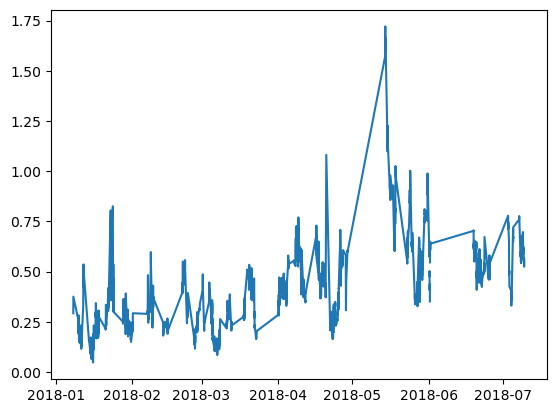

In [239]:
test_df = df.loc[(df['Datetime'] >= '2018-01-01') & (df['Datetime'] <= '2018-12-31')].sort_values('Datetime')
plt.plot(test_df['Datetime'],test_df['AOD_550nm'])

test_df.describe()

# Load INSAT 2016 DATA

In [262]:
#Loading AOD Dataset for testing 
aod_insat3D = glob.glob(aod_file[5]+'/*')

aod_insat3DR = glob.glob(aod_file[6]+'/*')


ds_3D = xr.open_mfdataset(aod_insat3D)
ds_3DR = xr.open_mfdataset(aod_insat3DR)

#slicing
#ds_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()
ds_combine = xr.concat([ds_3DR, ds_3D], dim='time')
ds_combine = ds_combine.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()

KeyError: "cannot represent labeled-based slice indexer for coordinate 'time' with a slice over integer positions; the index is unsorted or non-unique"

In [ ]:
ds_combine = ds_combine.where(ds_3D != -999, np.nan)

In [ ]:
ds_combine

In [243]:
# # Specify the center latitude and longitude for the subset
# center_lat = 25
# center_lon = 76

# # Define the size of the subset (in number of pixels)
# subset_size = 0.5

# t = ds_3D.sel(latitude=center_lat,longitude=center_lon,method='nearest')
# lat = t.latitude.values
# lon = t.longitude.values

# # Calculate the start and end lat/lon indices for the subset
# start_lat_idx = (lat - subset_size / 2)
# end_lat_idx = (lat + subset_size / 2)
# start_lon_idx = (lon - subset_size / 2)
# end_lon_idx = (lon + subset_size / 2)

# # Extract the subset from the dataset
# subset = ds_3D.sel(latitude=slice(end_lat_idx,start_lat_idx), longitude=slice(start_lon_idx, end_lon_idx)).mean(dim=['latitude','longitude'])
# t.AOD.plot()

In [ ]:
ds_combine.AOD.sel(latitude=lat_loc,longitude=lon_loc,method='nearest').plot()

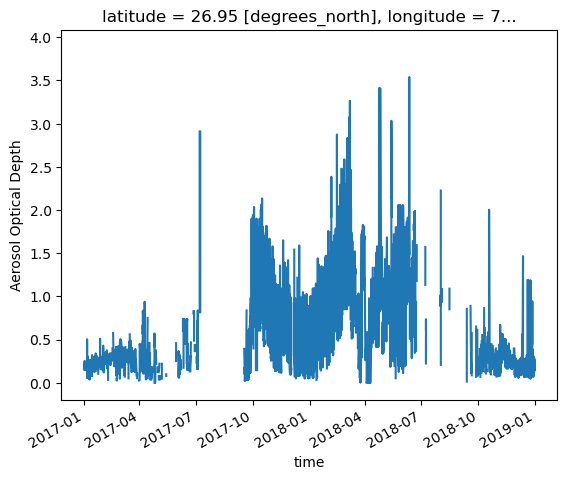

In [263]:
ds_3D.AOD.sel(latitude=lat_loc,longitude=lon_loc,method='nearest').plot()

### Create 5x5 pixel Spatial resolution i.e 50km x 50km around lat_loc and lon_loc

In [264]:
def spatialMethod(ds,lat,lon):

    out_res = 0.5

    
    interval_window = out_res/2
    
    new_grid_y = np.arange(lat-interval_window, lat+out_res, out_res) # Latitude label
    new_grid_x = np.arange(lon-interval_window, lon+out_res, out_res) # longitude Label

    print(new_grid_y,new_grid_x)
    gb = ds.groupby_bins('longitude', bins=new_grid_x).apply(
        lambda x: x.groupby_bins('latitude',bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=['latitude','longitude']).where(
                y.groupby('time').count(dim=['latitude','longitude'])>=12).where(
                y.groupby('time').std(dim=['latitude','longitude'])<=0.2
            )
        )
    )
    
    gb1 = gb.rename({"longitude_bins":"longitude","latitude_bins":"latitude"})
    #gb1["latitude"] = lat
    #gb1["longitude"] = lon
    
    return gb1

In [265]:
spatialAverage_AOD = spatialMethod(ds_3D,lat_loc,lon_loc)

[26.655817 27.155817] [75.556217 76.056217]


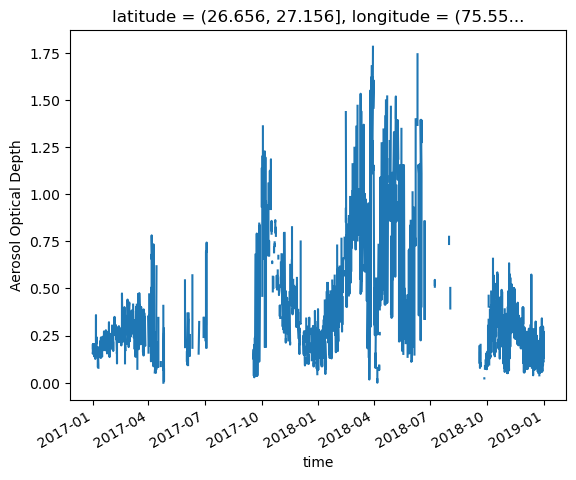

In [266]:
spatialAverage_AOD.AOD.plot()

### Create Time window of -30min and +30min 

In [267]:
def temporalMethod(df_resample,ds):
    
    # Specify the given time for which you want to count the data
    date = ds.time.dt.strftime('%Y-%m-%d %H:%M:%S').values
    date = pd.to_datetime(date)
    
    half_hourly_aeronet = pd.DataFrame(columns=['time', 'AOD_550nm'])

    for given_time in date:

        # Create time window of +30min and -30min from given_time
        time_before = given_time - timedelta(minutes=30)
        time_after = given_time + timedelta(minutes=30)

        # Filter the DataFrame for the time range around the given time
        df_time_interval = df_resample[(df_resample.Datetime >= time_before) & (df_resample.Datetime <= time_after)]

        # Atleast 3 valid Aeronet data should be there in time window
        if df_time_interval.AOD_550nm.count() >= 3 :
            aod_mean = df_time_interval.AOD_550nm.mean()
        
        else:
            aod_mean = np.NaN

        row = {'time': given_time.strftime('%Y-%m-%d %H:%M:%S'), 'AOD_550nm': aod_mean}
        half_hourly_aeronet = half_hourly_aeronet.append(row, ignore_index=True)
    
    return half_hourly_aeronet

In [268]:
# Take 2016 Aeronet Data
aeronet_data = df.loc[(df['Datetime'] >= '2016-01-01') & (df['Datetime'] <= '2016-12-31')].sort_values('Datetime')

# Taking half hourl Temporal Average of 2016 Aeronet Data
temporalAverage_aod = temporalMethod(df,spatialAverage_AOD)

In [269]:
temporalAverage_aod

,time,AOD_550nm
0,2017-01-01 05:30:00,NaN
1,2017-01-01 06:00:00,NaN
2,2017-01-01 06:30:00,NaN
3,2017-01-01 07:00:00,NaN
4,2017-01-01 07:30:00,NaN
...,...,...
4264,2018-12-31 06:30:00,NaN
4265,2018-12-31 07:00:00,NaN
4266,2018-12-31 07:30:00,NaN
4267,2018-12-31 08:00:00,NaN


In [270]:
spatialAverage_AOD

<xarray.Dataset>
Dimensions:    (time: 4269, latitude: 1, longitude: 1)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01T05:30:00 ... 2018-12-31T08:30:00
  * latitude   (latitude) object (26.656, 27.156]
  * longitude  (longitude) object (75.556, 76.056]
Data variables:
    AOD        (longitude, latitude, time) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [271]:
# Compare both Insat and Aeronet

insat_df = spatialAverage_AOD.to_dataframe().reset_index().drop(['latitude', 'longitude'], axis=1)
temporalAverage_aod['time'] = pd.to_datetime(temporalAverage_aod['time'])



In [272]:
insat_df

,time,AOD
0,2017-01-01 05:30:00,0.154722
1,2017-01-01 06:00:00,0.153825
2,2017-01-01 06:30:00,0.161211
3,2017-01-01 07:00:00,0.165882
4,2017-01-01 07:30:00,0.204295
...,...,...
4264,2018-12-31 06:30:00,0.154583
4265,2018-12-31 07:00:00,0.139547
4266,2018-12-31 07:30:00,0.270552
4267,2018-12-31 08:00:00,0.156484


In [273]:
temporalAverage_aod

,time,AOD_550nm
0,2017-01-01 05:30:00,NaN
1,2017-01-01 06:00:00,NaN
2,2017-01-01 06:30:00,NaN
3,2017-01-01 07:00:00,NaN
4,2017-01-01 07:30:00,NaN
...,...,...
4264,2018-12-31 06:30:00,NaN
4265,2018-12-31 07:00:00,NaN
4266,2018-12-31 07:30:00,NaN
4267,2018-12-31 08:00:00,NaN


In [274]:
merged_df = pd.merge(temporalAverage_aod,insat_df, on='time')
merged_df

,time,AOD_550nm,AOD
0,2017-01-01 05:30:00,NaN,0.154722
1,2017-01-01 06:00:00,NaN,0.153825
2,2017-01-01 06:30:00,NaN,0.161211
3,2017-01-01 07:00:00,NaN,0.165882
4,2017-01-01 07:30:00,NaN,0.204295
...,...,...,...
4264,2018-12-31 06:30:00,NaN,0.154583
4265,2018-12-31 07:00:00,NaN,0.139547
4266,2018-12-31 07:30:00,NaN,0.270552
4267,2018-12-31 08:00:00,NaN,0.156484


In [275]:
merged_df = merged_df.dropna(subset=['AOD_550nm', 'AOD'], how='any')
merged_df

,time,AOD_550nm,AOD
17,2017-01-03 07:00:00,0.416114,0.150594
18,2017-01-03 07:30:00,0.379934,0.191208
19,2017-01-03 08:00:00,0.362110,0.192559
20,2017-01-03 08:30:00,0.351857,0.189015
22,2017-01-04 07:00:00,0.403374,0.168878
...,...,...,...
3122,2018-06-21 06:00:00,0.484566,0.854251
3127,2018-06-22 06:00:00,0.457125,0.854251
3212,2018-07-08 05:30:00,0.551282,0.518594
3213,2018-07-08 06:00:00,0.555543,0.545341


In [276]:
merged_df.columns

Index(['time', 'AOD_550nm', 'AOD'], dtype='object')

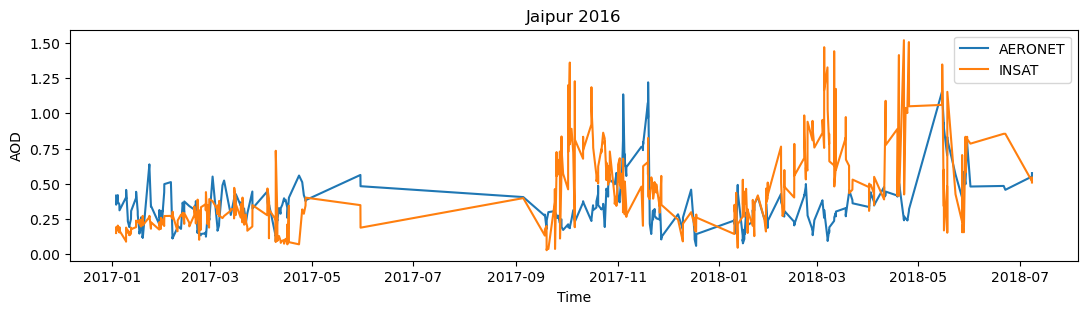

In [277]:
# Plot the data
fig, ax = plt.subplots(figsize=(13, 3))
ax.plot(merged_df['time'], merged_df['AOD_550nm'], label='AERONET')
ax.plot(merged_df['time'], merged_df['AOD'], label='INSAT')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('AOD')
ax.set_title('Jaipur 2016')
plt.show()

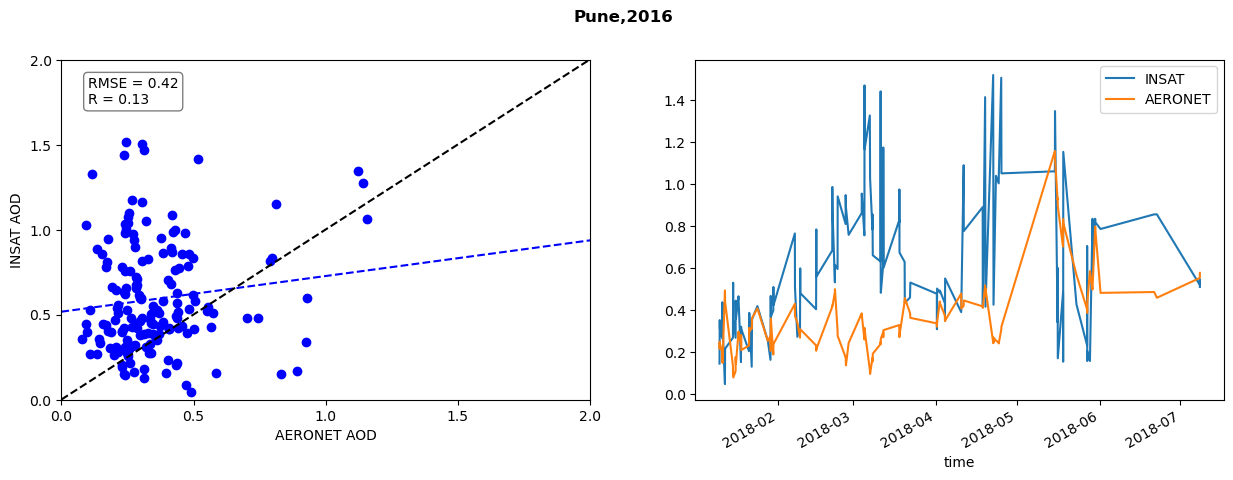

In [259]:
from sklearn.linear_model import LinearRegression


# Create the scatter plot
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes[0]
ax.scatter(merged_df['AOD_550nm'], merged_df['AOD'], color='blue')
ax.set_xlabel('AERONET AOD')
ax.set_ylabel('INSAT AOD')

# Calculate the regression line
regression = LinearRegression().fit(merged_df['AOD_550nm'].values.reshape(-1, 1), merged_df['AOD'].values.reshape(-1, 1))
slope = regression.coef_[0][0]
intercept = regression.intercept_[0]

# Calculate the limits
limit = max(merged_df['AOD_550nm'].max(), merged_df['AOD'].max())

# Add the regression line to the scatter plot
x_vals = np.arange(0,limit+2)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, '--', color='blue')

# RMSE and Corr
rmse = np.sqrt(np.mean((merged_df['AOD_550nm'] - merged_df['AOD']) ** 2))
corr_coef = np.corrcoef(merged_df['AOD_550nm'], merged_df['AOD'])[0,1]

# Add RMSE and correlation coefficient as text inside the plot
textstr = f'RMSE = {rmse:.2f}\nR = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


# Calculate the step
step = 0.5

# Set the limits and step to be the same for both axes
ax.set_xlim([0, limit])
ax.set_ylim([0, limit])
ax.set_xticks(np.arange(0, limit+step, step))
ax.set_yticks(np.arange(0, limit+step, step))
ax.plot(ax.get_xlim(),ax.get_xlim(), '--', color='black')

ax = axes[1]
merged_df.plot(x='time', y=['AOD', 'AOD_550nm'],label=['INSAT','AERONET'], ax=ax)

#plt.savefig('./plots/aod_plot/scatter_plot/kanpur_2015_scatter')
# Display the plot

plt.suptitle('Pune,2016',weight='bold')
plt.show()